In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

In [2]:
import numpy as np 
import pandas as pd 
import glob
import matplotlib.pyplot as plt
import random
import math
import cv2
import os
import warnings
import gc
from IPython.display import Image, display

warnings.filterwarnings('ignore')

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model

# Define Custom Functions

In [3]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)

set_verbosity(INFO)

# The GRAD-CAM Visualisation Function

**The Grad-Cam is calculated by the function 'grad_cam' , and 'compute_gradcam' calls the previous function and then plots the heatmaps. 

Again the 'load_image' function is called in the 'grad_cam' function before calculating the grad_cam.
Again the 'get_mean_std_per_batch' function is called inside the 'load_image' function for prepricessing purposes.

Hence, all four of these functions are needed to compute and plot the heat map.

In a code , we will directly and only call the 'compute_gradcam' function.

The versions of the packages must match otherwise it will show error.**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import backend as K

In [5]:
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen class) with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, we will also normalize the heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return K.eval(heatmap)


In [7]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.preprocessing import image

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)
    #print(img.shape)

    # Resize the heatmap to match the original image size using Keras utilities
    heatmap = cv2.resize(heatmap , (img.shape[1], img.shape[0]))
    #heatmap = tf.keras.utils.img_to_array(heatmap_img)[:, :, np.newaxis]
    #print(heatmap.shape)

    # Convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # Apply the heatmap as an overlay on the original image
    jet_heatmap = cv2.applyColorMap(heatmap, cv2.COLOR_BGR2RGB)
    #jet_heatmap = jet_heatmap.astype(np.float32) / 255.0
    #heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    #print(jet_heatmap.shape)

    # Use jet colormap to colorize heatmap
    #jet = mpl.cm.get_cmap("jet")

    # Use RGB values of the colormap
    #jet_colors = jet(np.arange(256))[:, :3]

    # Normalize the heatmap
    #jet_heatmap = jet_colors[heatmap]
    #print(jet_heatmap.shape)

    # Ensure both arrays have the same data type
    img = img.astype(np.float32)
    jet_heatmap = jet_heatmap.astype(np.float32)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img, 0.6, jet_heatmap, 0.4, 0)

    # Convert the resulting image back to uint8 for display
    superimposed_img = np.uint8(superimposed_img)
    
    return superimposed_img 

    # Display the superimposed image
    #plt.imshow(superimposed_img)
    #plt.axis('off')
    #plt.show()

# Extract Data 

In [8]:
consolidation_files = pd.read_csv('/kaggle/input/consolidation-mimic-reports/consolidation_captions.txt')

consolidation_files

,image,caption
0,../input/curated-cxr-report-generation-dataset...,Bilateral perihilar consolidation
1,../input/curated-cxr-report-generation-dataset...,lower lobe consolidation
2,../input/curated-cxr-report-generation-dataset...,Bibasilar consolidations
3,../input/curated-cxr-report-generation-dataset...,Extensive bilateral diffuse consolidation
4,../input/curated-cxr-report-generation-dataset...,bilateral airspace consolidation
...,...,...
5630,../input/curated-cxr-report-generation-dataset...,Previous right basal consolidation
5631,../input/curated-cxr-report-generation-dataset...,the consolidation
5632,../input/curated-cxr-report-generation-dataset...,new substantial right upper lobe consolidation
5633,../input/curated-cxr-report-generation-dataset...,The right upper and lower lobe consolidations


In [9]:
consolidation_files['patient'] = consolidation_files['image'].apply(lambda x: os.path.splitext(x.split('/')[-1])[0])

consolidation_files

,image,caption,patient
0,../input/curated-cxr-report-generation-dataset...,Bilateral perihilar consolidation,s58601378
1,../input/curated-cxr-report-generation-dataset...,lower lobe consolidation,s57741802
2,../input/curated-cxr-report-generation-dataset...,Bibasilar consolidations,s50522426
3,../input/curated-cxr-report-generation-dataset...,Extensive bilateral diffuse consolidation,s54654246
4,../input/curated-cxr-report-generation-dataset...,bilateral airspace consolidation,s59262594
...,...,...,...
5630,../input/curated-cxr-report-generation-dataset...,Previous right basal consolidation,s50603948
5631,../input/curated-cxr-report-generation-dataset...,the consolidation,s56043298
5632,../input/curated-cxr-report-generation-dataset...,new substantial right upper lobe consolidation,s50014291
5633,../input/curated-cxr-report-generation-dataset...,The right upper and lower lobe consolidations,s55728985


# The Labels used in the Model

In [10]:
labels = ['No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity','Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis','Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']

# Load The Model

In [11]:
model = tf.keras.models.load_model('/kaggle/input/multi-label-version-2/multi_disease_model_v2_new.h5')

Instructions for updating:
Colocations handled automatically by placer.


2024-01-02 15:01:31.136958: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-02 15:01:31.137061: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-02 15:01:31.137190: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-02 15:01:31.137278: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-02 15:01:31.137377: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-02 15:01:31.137600: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-02 15:01:31.137694: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 64, 32)        128   

In [13]:
def find_last_conv_layer(model):
    """
    Find the last convolutional layer in the given model.
    """
    for layer in reversed(model.layers):
        #print(layer.name)
        if 'conv' in layer.name:
            return layer.name
    return None

In [14]:
last_conv_layer = find_last_conv_layer(model)

print(last_conv_layer)

conv_pw_13_relu


In [15]:
class_labels = model.output_names
print("Class Labels:", class_labels)

Class Labels: ['dense_1']


# Test with one Image

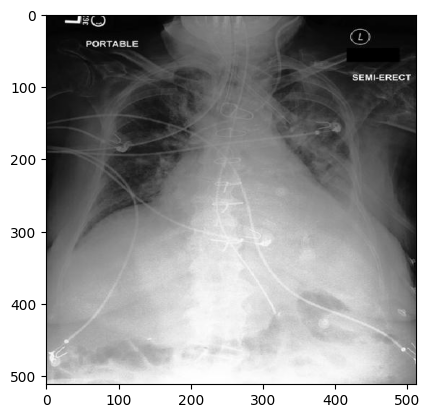

In [16]:
path = consolidation_files['image'].iloc[40]

I = cv2.imread(consolidation_files['image'].iloc[40])
plt.imshow(I)

# Predict Grad-CAM

In [17]:
cls = labels.index('Consolidation')

cls

6

In [18]:
img_array = load_and_preprocess_image(path)

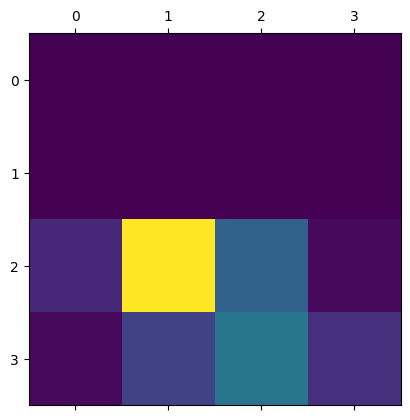

In [19]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [20]:
#print(heatmap.shape)

In [21]:
gradcam = save_and_display_gradcam(path,heatmap)

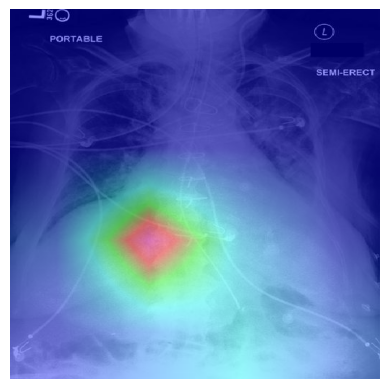

In [22]:
plt.imshow(gradcam)
plt.axis('off')
plt.show()

# Save the Grad-CAMS

In [23]:
from tqdm import tqdm
from tqdm.notebook import tqdm
!pip install progressbar2
import progressbar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [24]:
import os

In [25]:
out = "/kaggle/working/Consolidation_GRAD_CAMS"
os.makedirs(out, exist_ok=True)

In [ ]:
for index, row in progressbar.progressbar(consolidation_files.iterrows()):
    
    img_path = row['image']
    img_id = row['patient']
        
    img_array = load_and_preprocess_image(img_path)

    # Generate the heatmap using make_gradcam_heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)
    
    gradcam = save_and_display_gradcam(img_path,heatmap)

    # Save the Grad-CAM image
    gradcam_name = f"{img_id}_GRAD_CAM.jpg"
    
    out_path = os.path.join(out, gradcam_name)
    
    cv2.imwrite(gradcam_name, gradcam , [int(cv2.IMWRITE_JPEG_QUALITY), 95])

/ |                                           #     | 148 Elapsed Time: 2:01:46https://symbolize.stripped_domain/r/?trace=7caf7fb96e45,7cb051480fcf,7caf7fb9990a,7caf7f8d0d35,7caf7f838a8c,7caf7f8341e4,7caf7f980cda,7caf7ed443cc,7caf7ed47982,7caf7b9f5936,7caf7b9f5bfb,7caf7b9f5ba0,7caf7de7bf51,7caf7f889e8e,7caf6db8df76,7caf6db9e94d,7caf55f0eea4,7caf55ed9d57,7cb05179b30c&map= 
*** SIGTERM received by PID 13 (TID 13) on cpu 85 from PID 1; stack trace: ***
PC: @     0x7caf7fb96e45  (unknown)  tensorflow::NodeDef_ExperimentalDebugInfo::NodeDef_ExperimentalDebugInfo()
    @     0x7caf64cc6ada       1152  (unknown)
    @     0x7cb051480fd0  (unknown)  (unknown)
    @     0x7caf7fb9990b         32  google::protobuf::Arena::CreateMaybeMessage<>()
    @     0x7caf7f8d0d36       1376  tensorflow::InlineFunctionBody()
    @     0x7caf7f838a8d        672  tensorflow::RewriteFunctionCallNode()
    @     0x7caf7f8341e5        176  tensorflow::LowerFunctionalOpsPass::Run()
    @     0x7caf7f980cdb       